# Deafening control analysis

In [1]:
%load_ext autoreload
%load_ext usnm2p.skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import os
import jupyter_slack
import datetime
from statannotations.Annotator import Annotator

# Internal modules
from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import *
from usnm2p.indexers import *
from usnm2p.fileops import *
from usnm2p.postpro import *
from usnm2p.plotters import *
from usnm2p.batchutils import *
from usnm2p.parsers import extract_FOV_area, resolve_mouseline, parse_date_mouse_region

# Figures dictionary
figs = {}

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Parameters

### Input datasets and main processing parameters

In [ ]:
# Processing parameters
analysis_type = 'main'  # Analysis type
mouseline = 'cre_sst'  # mouse line
layer = None  # cortical layer
slack_notify = False
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
gcamp_key = get_gcamp_key(mouseline)  # GCaMP channel key
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = False  # whether to look for directional (i.e. positive only) effect for response detection

# Plotting parameters
xkeys_plt = [  # input parameters
    Label.P,
    Label.DC,
    Label.ISPTA
]
ykey_plt = Label.ZSCORE  # plotting variable

### Derived parameters

In [12]:
# If global correction is dictionary, extract line-specific method
if isinstance(global_correction, dict):
    global_correction = global_correction[mouseline]

# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_id = get_baseline_id(baseline_quantile, baseline_wquantile, baseline_wsmoothing)

ispv = mouseline == 'pv'
isnotpv = not ispv

# Resolve red channel name
red_channel_key = mouseline.split('_')[1].upper()

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2025/06/24 17:17:10: assembling batch analysis settings...
 2025/06/24 17:17:10: cre_ndnf main analysis notebook started on 2025-06-24 at 17:17:10


### Input summary table figure

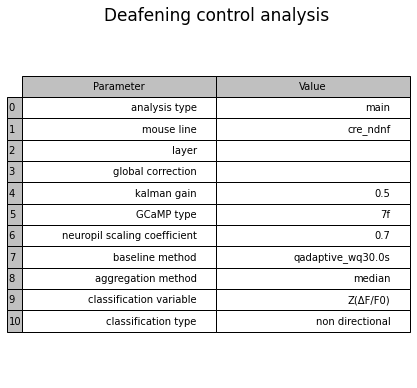

In [13]:
figs['dataset_info'] = plot_table({
    'analysis type': analysis_type,
    'mouse line': mouseline,
    'layer': layer,
    'global correction': global_correction,
    'kalman gain': kalman_gain,
    'GCaMP type': gcamp_key,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline method': baseline_id,
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    }, title='Deafening control analysis', aspect=1.5)

## Load & inspect initial data

### Load data

In [14]:
# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop_last'

# Load datasets
logger.info(f'loading data from {input_dir}:')
data = load_processed_datasets(
    input_dir, layer=layer,
    exclude_patterns=None,
    on_duplicate_runs=on_duplicate_runs)
logger.info('data successfully loaded.')

# Parse dates, mice and regions from datasets
datasets = data[list(data.keys())[0]].index.unique(level=Label.DATASET).tolist()
datasets_info = parse_date_mouse_region(datasets)

# Remap dataset names to more informative "pre-deafening" and "post-deafening" labels
logger.info('remapping dataset names to more informative labels')
assert datasets_info['mouse'].nunique() == 1, 'multiple mice in datasets'
assert len(datasets_info) == 2, 'more than 2 datasets'
prepostkeys = ['pre-deafening', 'post-deafening']
mapper = dict(zip(datasets_info.index.tolist(), prepostkeys))

hue_order = list(Palette.DEAFENING.keys())
for k, v in data.items():
    if isinstance(v, (pd.DataFrame, pd.Series)):
        v.index = v.index.set_levels(v.index.levels[0].map(mapper), level=Label.DATASET)
    elif isinstance(v, dict):
        data[k] = {mapper[kk]: vv for kk, vv in v.items()}

 2025/06/24 17:17:16: loading data from /gpfs/scratch/lemait01/data/usnm/processed/aggmedian_classzscore/alpha0.7_qadaptive_wq30.0s/suite2p_fs_5.0_nchannels_2_reg_tif_reg_tif_chan2_tau_0.7/kd_G0.5_V0.05_npad10/submap_stim-1->stimeverytrial/30.0Hz_5.0Hz_smooth/main/cre_ndnf:
 2025/06/24 17:17:16: gathering dataset IDs...
 2025/06/24 17:17:16: loading mouse-region data from 20200901_mouse6172_region1.h5
 2025/06/24 17:17:16: loading mouse-region data from 20200917_mouse6172_region1.h5
 2025/06/24 17:17:17: assembling data structures...
 2025/06/24 17:17:18: harmonizing run index by param across datasets
 2025/06/24 17:17:18: generating expanded conditions...
 2025/06/24 17:17:21: expanding "trialagg_stats" condition to match "trialagg_timeseries" timeseries
 2025/06/24 17:17:22: expanding "stats" condition w/o. ['ROI'] dimensions to match "popagg_timeseries" timeseries
 2025/06/24 17:17:22: updating trialagg_timeseries run index
 2025/06/24 17:17:22: updating popagg_timeseries run index


### Unpack data and get ROI counts

In [15]:
# Unpack
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, map_ops = extract_from_batch_data(data)

# Extract number of frames per trial from timeseries multi-index
nframes_per_trial = popagg_timeseries.index.unique(level=Label.FRAME).max() + 1

# Assemble frame indexer object
tref = get_stim_onset_time(mouseline)
fps = get_singleton(trialagg_stats, Label.FPS)
fidx = FrameIndexer.from_time(tref, TPRE, TPOST, 1 / fps, npertrial=nframes_per_trial)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(trialagg_stats, style=True)

 2025/06/24 17:17:23: extracting timeseries and stats from data...
 2025/06/24 17:17:23: detailed ROI count:


### Extract red vs non-red cells

 2025/06/24 17:19:24: extracting CH2 cells stats ...


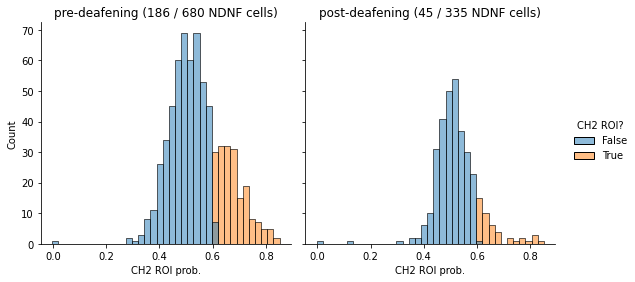

In [20]:
# Extracting cells "CH2" stats
logger.info('extracting CH2 cells stats ...')
coreg_stats = (
    trialagg_stats[[Label.CH2_ROI_PROB, Label.CH2_ROI]]
    .groupby([Label.DATASET, Label.ROI], sort=False)
    .first()
)

# Identify red channel cells by thresholding ROI-overlaps between CH1 and CH2
overlap_thr = 0.6
coreg_stats[Label.CH2_ROI] = coreg_stats[Label.CH2_ROI_PROB] > overlap_thr
counts = (
    coreg_stats[Label.CH2_ROI]
    .groupby(Label.DATASET, sort=False)
    .agg(['sum', 'size'])
    .rename(columns={'sum': red_channel_key, 'size': 'total'})
)
g = sns.displot(
    data=coreg_stats,
    x=Label.CH2_ROI_PROB,
    col=Label.DATASET,
    hue=Label.CH2_ROI,
    height=4
)
for k, ax in g.axes_dict.items():
    ax.set_title(f'{k} ({counts.loc[k, red_channel_key]} / {counts.loc[k, "total"]} {red_channel_key} cells)')
figs['coreg probs'] = g.fig

# Add co-registered cells information to data
trialagg_stats[Label.CH2_ROI] = coreg_stats[Label.CH2_ROI]
ext_stats[Label.CH2_ROI] = coreg_stats[Label.CH2_ROI]
trialagg_timeseries[Label.CH2_ROI] = coreg_stats[Label.CH2_ROI]

### Inspect cell maps

 2025/06/24 17:19:48: sorted cell densities:
post-deafening    1277.923584
pre-deafening     2593.994141
dtype: float64
 2025/06/24 17:19:48: plotting cell maps...


100%|██████████| 2/2 [00:08<00:00,  4.48s/it]


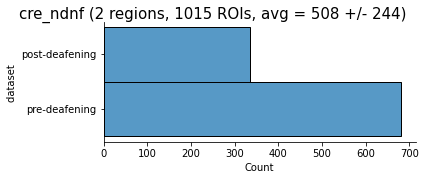

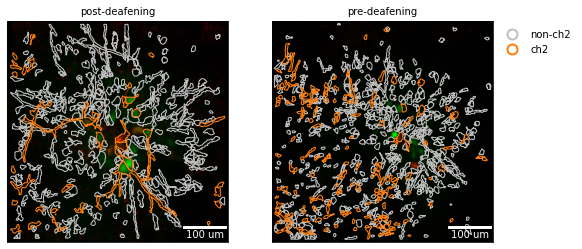

In [21]:
figs['cellcounts'] = plot_cellcounts(trialagg_stats, hue=None, title=mouseline)

# Compute ROI density for each dataset
FOV_areas = pd.Series({k: extract_FOV_area(v) for k, v in map_ops.items()})  # mm2
ROI_counts = get_detailed_ROI_count(trialagg_stats).max(axis=1).astype(int)  # cells
ROI_densities = ROI_counts / FOV_areas  # cells/mm2
logger.info(f'sorted cell densities:\n{ROI_densities.sort_values()}')

# Plot cell maps and highlight outlier datasets
figs['cellmaps'] = plot_fields_of_view(
    map_ops, 
    # refkey='max_proj',
    ROI_masks=ROI_masks, 
    Fstats=trialagg_stats,
    hue=Label.CH2_ROI, # None
    mode='contour', 
    qmax=.999,
    height=5,
)

### Inspect baseline variation throughout experiments and exclude outlier datasets

 2025/06/24 17:20:32: inspecting relative variations in baseline fluorescence across experiments...


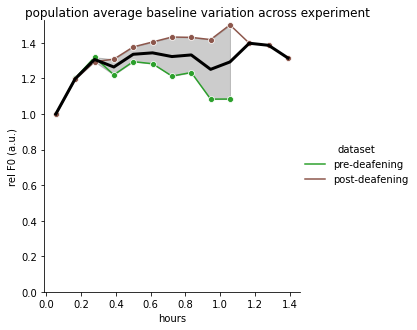

In [22]:
runid_maps = trialagg_stats[Label.RUNID].groupby([Label.DATASET, Label.RUN]).first()

def get_rel_F0(data, F0_key=Label.F0, aggbyrun=True):
    ''' Extract temporal evolution of F0 over experiment '''
    # Figure out dataset ID and associated run order
    dataset_id = data.index.unique(Label.DATASET)[0]
    # Add time along entire experiment to population-average dataframe average
    idx = get_index_along_experiment(data.index, runid_map=runid_maps.loc[dataset_id])
    data[Label.TIME] = idx / fps
    # If specified, aggregate by run
    if aggbyrun:
        data = data.groupby(Label.RUN).median()
    # Compute relative variation from max
    yref = data.sort_values(Label.TIME)[F0_key].iloc[0]
    # yref = data[F0_key].max()
    relF0_key = f'rel {F0_key}'
    data[relF0_key] = data[F0_key] / yref
    # Return data of interest
    return data[[Label.TIME, relF0_key]]

# Compute relative variation of average baseline along experiment, for each dataset
logger.info('inspecting relative variations in baseline fluorescence across experiments...')
aggbyrun = True
F0_key = Label.F0
relF0_key = f'rel {F0_key}'
popagg_F0_per_run = (
    popagg_timeseries
    .groupby(Label.DATASET)
    .apply(lambda x: get_rel_F0(x, F0_key=F0_key, aggbyrun=aggbyrun))
)
popagg_F0_per_run[Label.HOURS] = popagg_F0_per_run[Label.TIME] / 3600

# Plot time evolution of average baseline along experiment, for each dataset
pltkwargs = dict(
    x=Label.HOURS,
    y=relF0_key,
)
fg = sns.relplot(
    kind='line',
    data=popagg_F0_per_run,
    errorbar=None, 
    hue=Label.DATASET,
    hue_order=hue_order,
    marker='o',
    palette=Palette.DEAFENING,
    aspect=1.,
    height=3 if not aggbyrun else 4.5,
    col=Label.DATASET if not aggbyrun else None,
    col_wrap=4 if not aggbyrun else None,
    **pltkwargs,
)
sns.despine(fig=fg.figure)
figs['popavg F0 across experiment'] = fg.figure
fg.figure.suptitle('population average baseline variation across experiment', y=1.01)
for ax in fg.figure.axes:
    ax.set_ylim(0, ax.get_ylim()[1])
if aggbyrun:
    # Add average trace across valid datasets
    sns.lineplot(
        ax=ax,
        data=popagg_F0_per_run,
        lw=3, 
        color='k',
        legend=False,
        **pltkwargs
    )

## Response curves

### Plot trial heatmap per condition for entire mouse line

 2025/06/24 17:20:37: post-deafening: original 544375-rows series is already rectilinear -> ignoring
 2025/06/24 17:20:37: pre-deafening: expanding 850000-rows series into 680 ROIs x 13 runs x 125 frames (1105000-rows) series (255000 additional rows)
 2025/06/24 17:20:37: adding time info to table...
 2025/06/24 17:20:38: plotting Z(ΔF/F0) trial heatmaps...


13it [00:11,  1.16it/s]                        


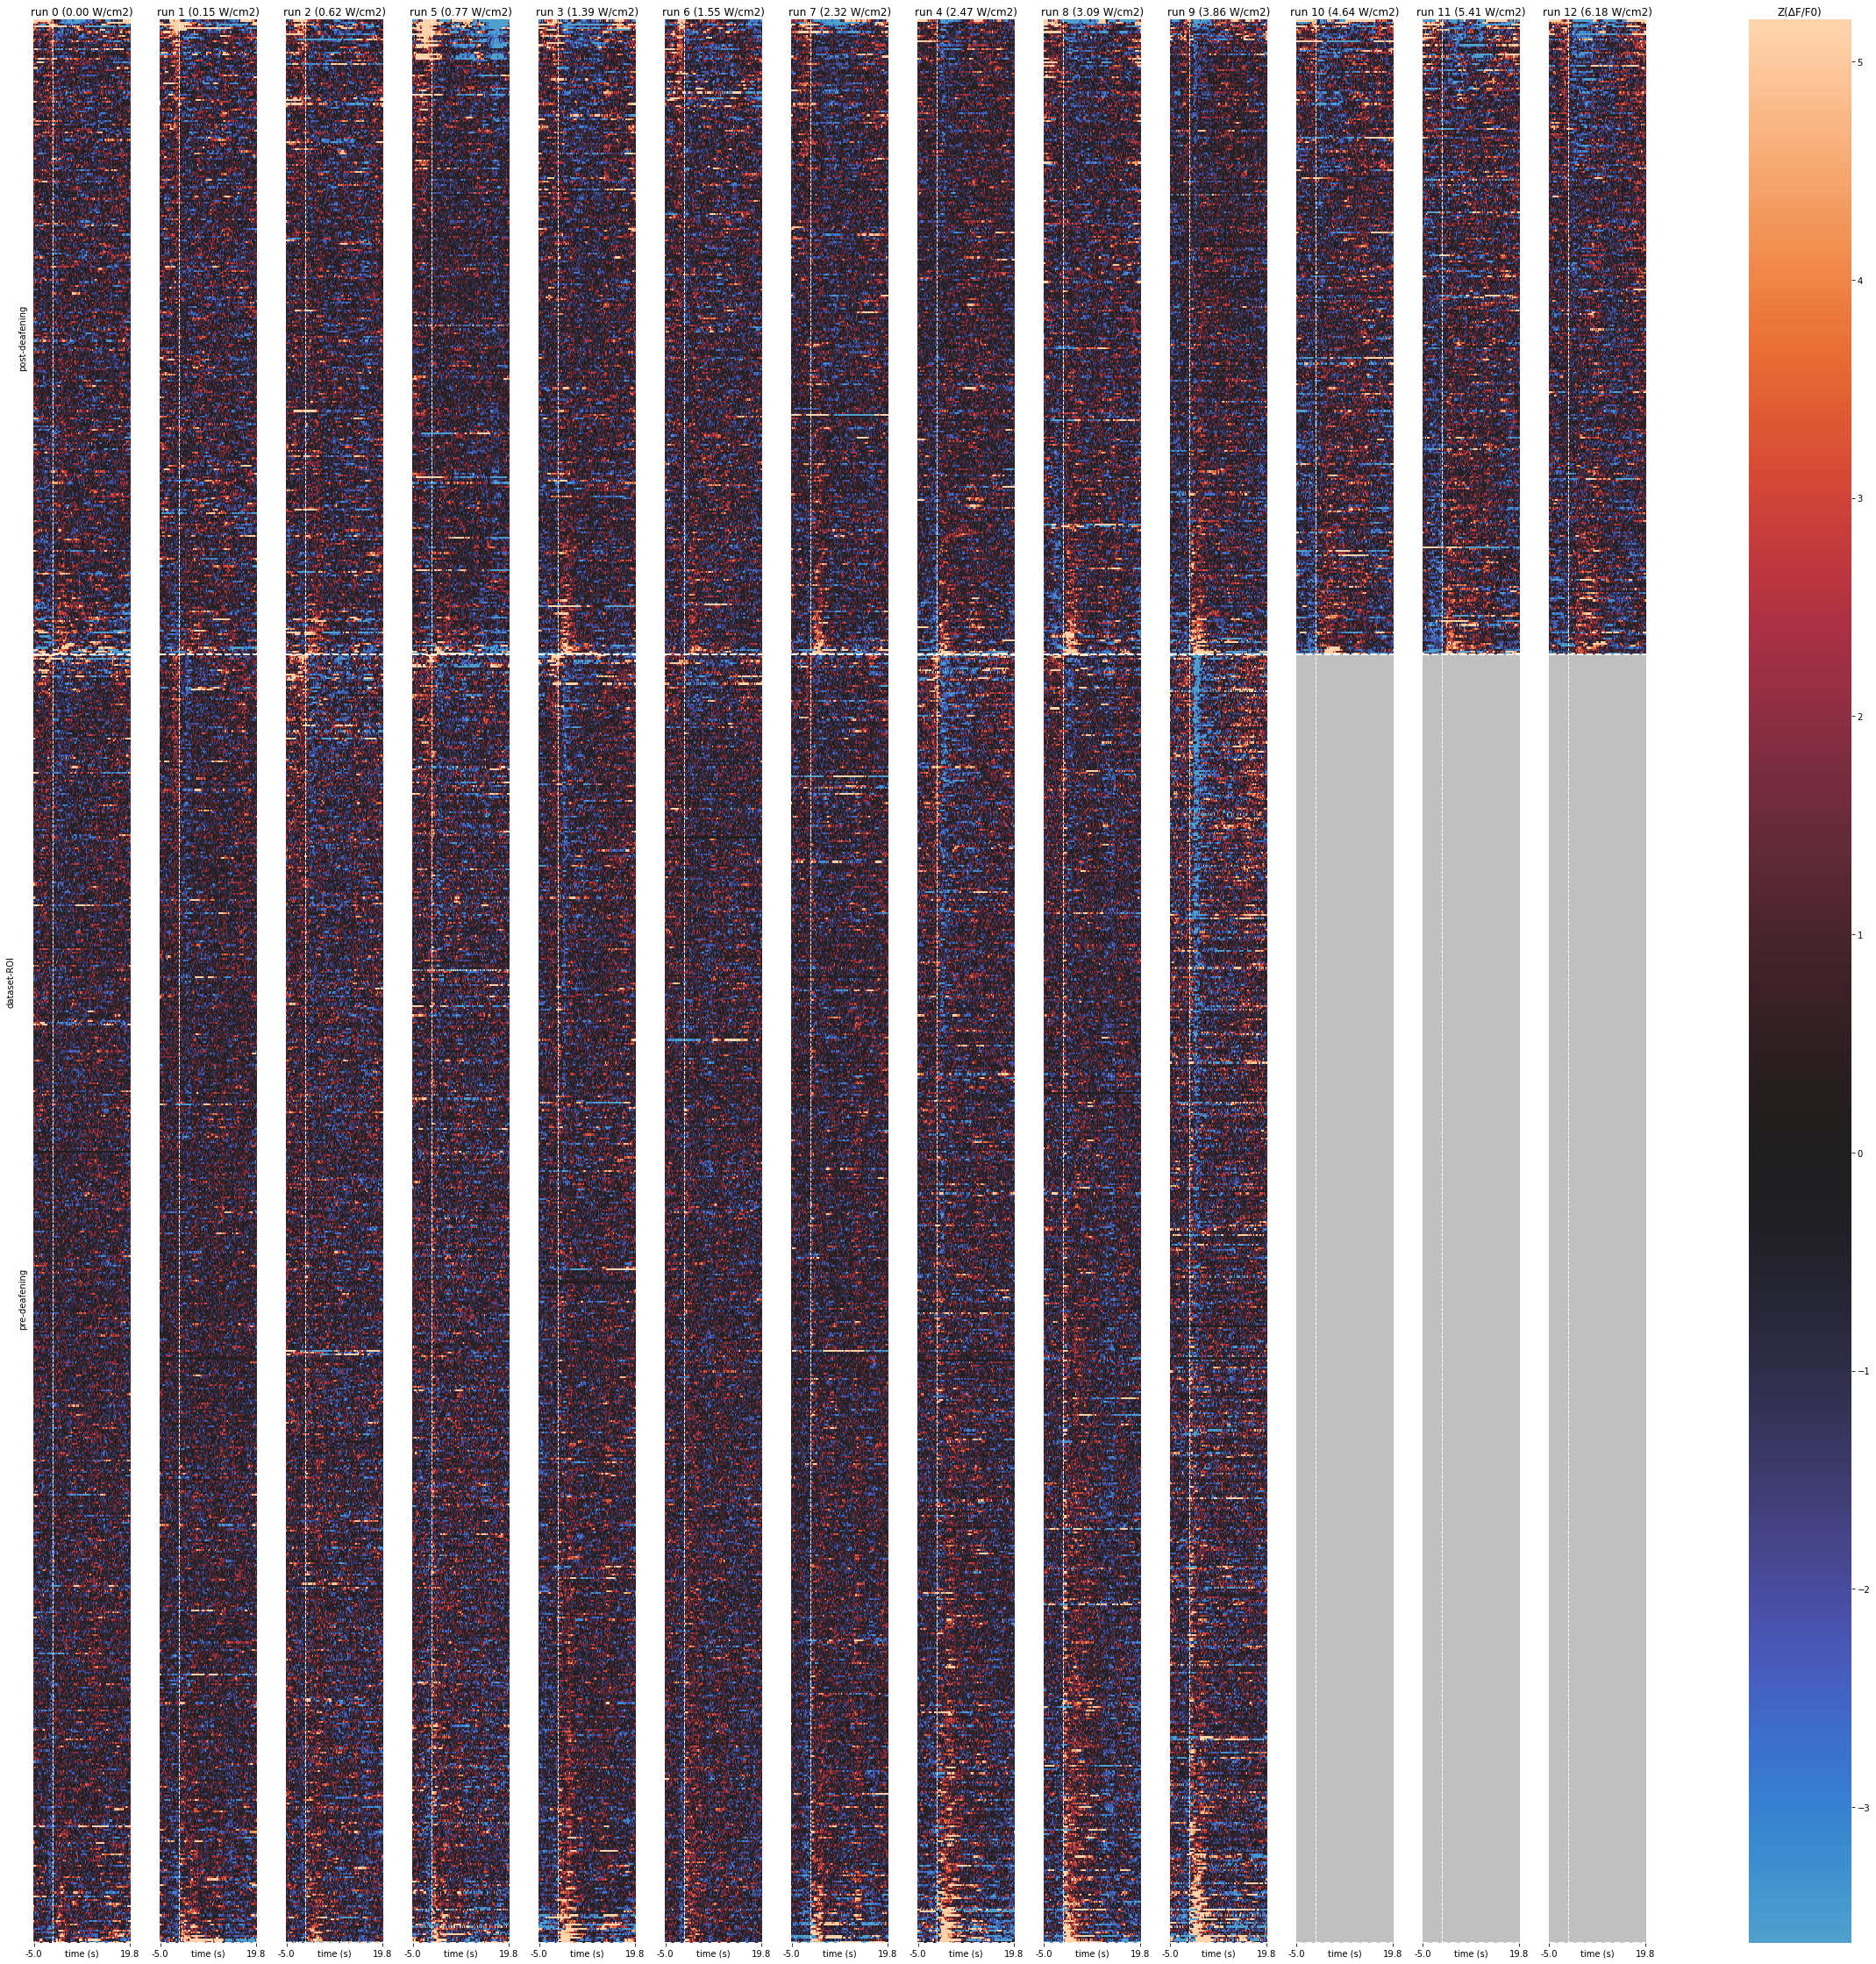

In [23]:
sorted_ISPTAs = (trialagg_stats[Label.ISPTA]
    .groupby(Label.RUN)
    .first()
    .sort_values()
    .apply('{:.2f} W/cm2'.format)
)

figs[f'{ykey_plt} heatmap'] = plot_activity_heatmap(
    trialagg_timeseries, ykey_plt, fidx, fps, col=Label.RUN,
    col_order=sorted_ISPTAs.index.values, 
    col_labels=sorted_ISPTAs.values,
    rasterized=True,
    colwrap=len(sorted_ISPTAs), 
    sort_ROIs=True,
    height_factor=3,
)

 2025/06/24 17:22:08: extracting data for cells identified in red channel ...
 2025/06/24 17:22:08: post-deafening: original 73125-rows series is already rectilinear -> ignoring
 2025/06/24 17:22:08: pre-deafening: expanding 232500-rows series into 186 ROIs x 13 runs x 125 frames (302250-rows) series (69750 additional rows)
 2025/06/24 17:22:08: adding time info to table...
 2025/06/24 17:22:09: plotting Z(ΔF/F0) trial heatmaps...


13it [00:05,  2.24it/s]                        


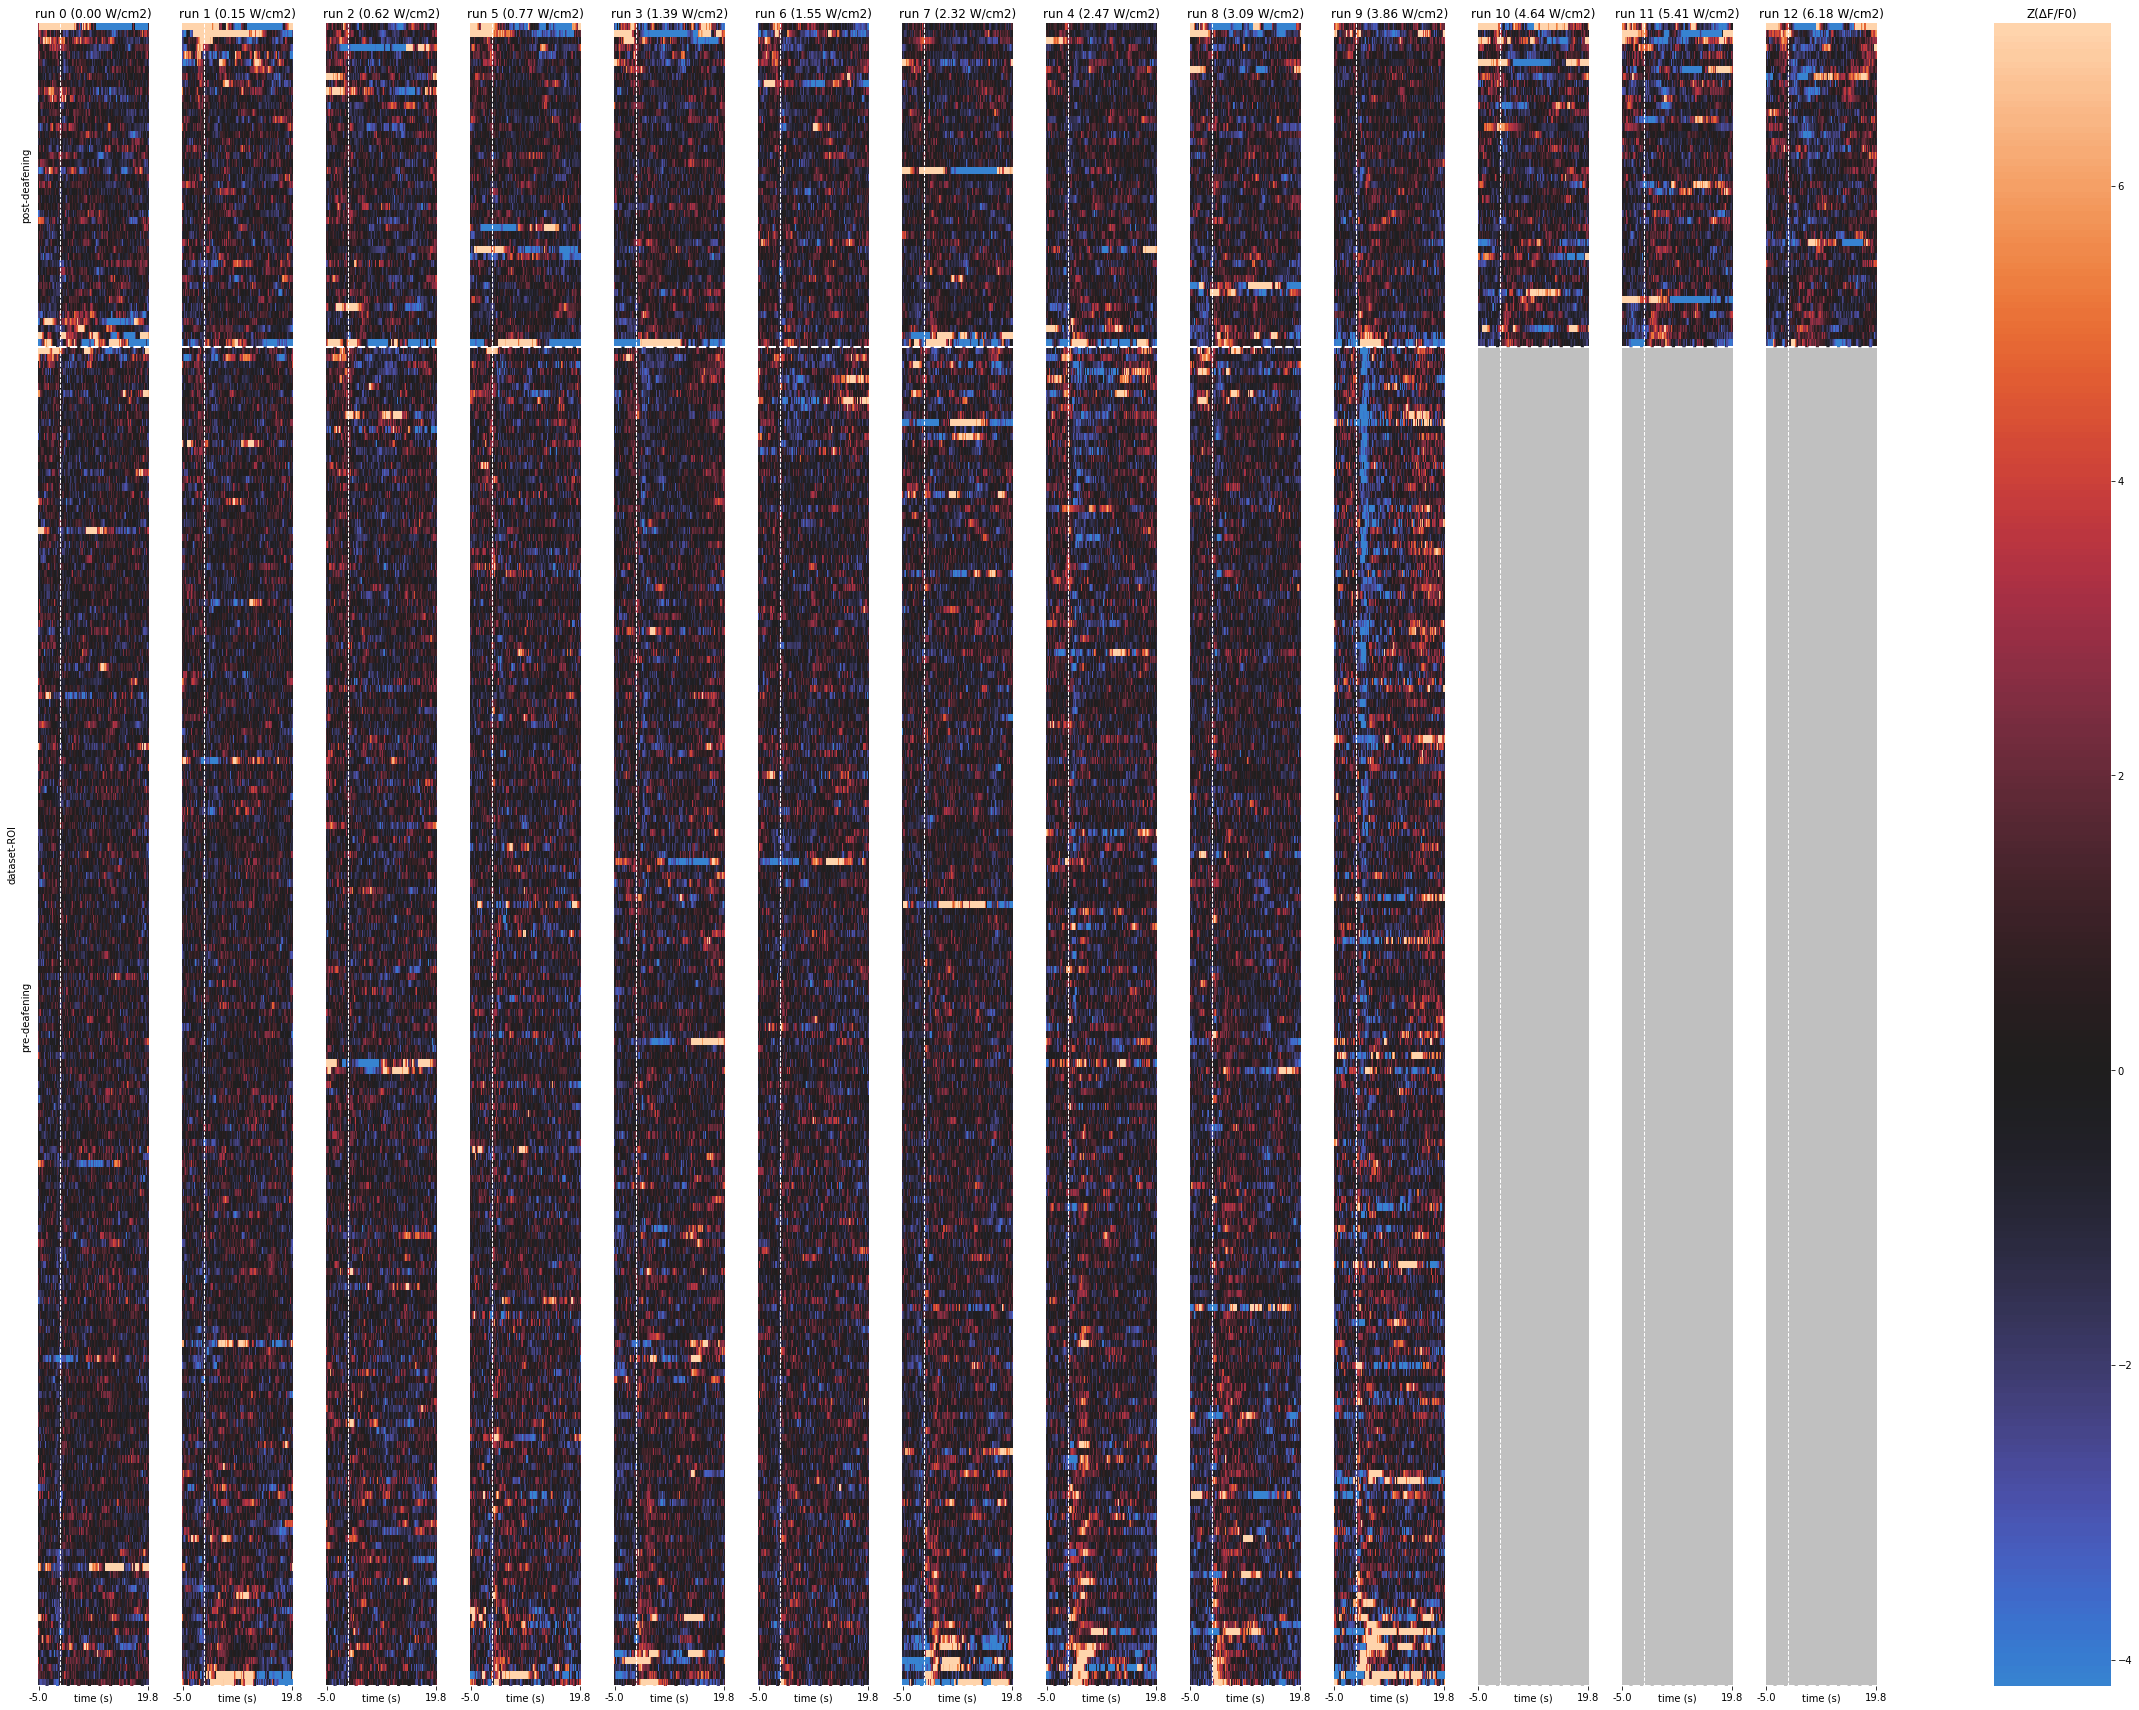

In [24]:
# Extracting data for cells co-registred in red channel
logger.info('extracting data for cells identified in red channel ...')
coreg_trialagg_stats = trialagg_stats[trialagg_stats[Label.CH2_ROI]]
coreg_ext_stats = ext_stats[ext_stats[Label.CH2_ROI]]
coreg_trialagg_timeseries = trialagg_timeseries[trialagg_timeseries[Label.CH2_ROI]]

figs[f'{ykey_plt} heatmap ch2'] = plot_activity_heatmap(
    coreg_trialagg_timeseries, ykey_plt, fidx, fps, col=Label.RUN,
    col_order=sorted_ISPTAs.index.values, 
    col_labels=sorted_ISPTAs.values,
    rasterized=True,
    colwrap=len(sorted_ISPTAs), 
    sort_ROIs=True,
    height_factor=10,
)

### Quantify stimulus-evoked responses, classify responses & responders

 2025/06/24 17:22:43: loaded post-stimulus window size = 29 samples
 2025/06/24 17:22:43: applying mean function on Z(ΔF/F0) in [18-26] index window across dataset, ROI, run
 2025/06/24 17:22:43: applying mean function on Z(ΔF/F0) in [26-55] index window across dataset, ROI, run
 2025/06/24 17:22:43: computing evoked Z(ΔF/F0) change...
 2025/06/24 17:22:43: classifying responses using z-score thresholding ...
 2025/06/24 17:22:43: computing fraction of response occurence per ROI over 7 "strong ISPTA" conditions...
 2025/06/24 17:22:43: classiying ROIs as a function of their response occurence fractions...


responder type  negative  positive  weak
dataset                                 
post-deafening         3        10   322
pre-deafening         24        55   601

 2025/06/24 17:22:44: expanding (2 datasets x 856 ROIs) input dataframe to match (2 datasets x 856 ROIs x 13 runs) reference dataframe
 2025/06/24 17:22:44: expanding (2 datasets x 856 ROIs) input dataframe to match (2 datasets x 856 ROIs x 13 runs x 16 trials) reference dataframe
 2025/06/24 17:22:46: expanding (2 datasets x 856 ROIs) input dataframe to match (2 datasets x 856 ROIs x 13 runs x 125 frames) reference dataframe
 2025/06/24 17:22:47: extracting data for positive responders...
 2025/06/24 17:22:48: post-deafening: original 16250-rows series is already rectilinear -> ignoring
 2025/06/24 17:22:48: pre-deafening: expanding 68750-rows series into 55 ROIs x 13 runs x 125 frames (89375-rows) series (20625 additional rows)
 2025/06/24 17:22:48: adding time info to table...
 2025/06/24 17:22:48: plotting Z(ΔF/F0) trial heatmaps...


13it [00:03,  3.63it/s]                        


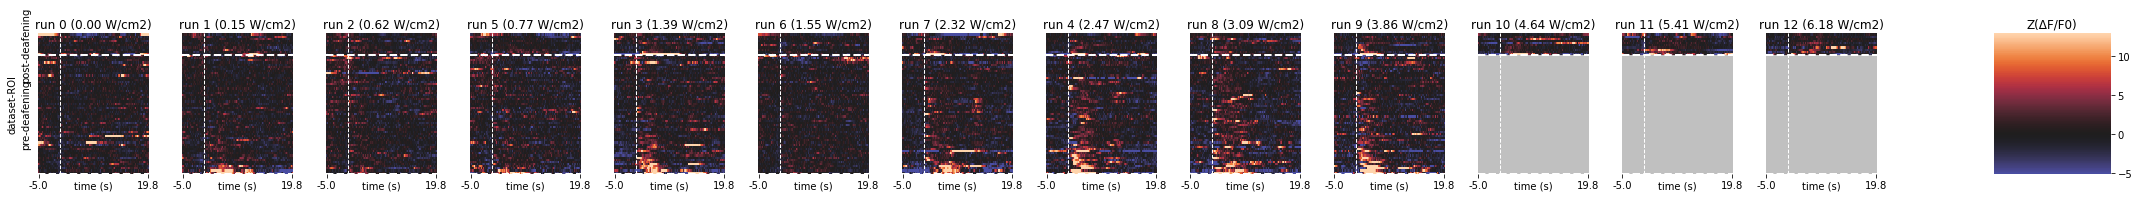

In [25]:
# Load post-stimulus window size from file, if available
try:
    npost = load_post_window_size(input_dir)
    logger.info(f'loaded post-stimulus window size = {npost} samples')
    fidx.npost = npost
except (ValueError, FileNotFoundError) as err:
    logger.warning(f'{err} -> resorting to default npost')

# Compute evoked responses
ykey_diff = get_change_key(ykey_plt)
trialagg_stats[ykey_diff] = compute_evoked_change(
    trialagg_timeseries, ykey_plt, fidx)

# Classify responses based on z-score value
zthr = pvalue_to_zscore(PTHR_DETECTION, directional=directional)
trialagg_stats[Label.RESP_TYPE] = zscore_to_resp_type(
    trialagg_stats[ykey_diff], zthr, directional=directional)

# Classify responders based on fraction of non-weak responses across experiment
roistats = classify_ROIs(trialagg_stats, directional=directional)
roitypes = roistats[Label.ROI_RESP_TYPE]
display(roitypes
    .groupby(Label.DATASET)
    .value_counts()
    .unstack()
)
trialagg_stats = free_expand_and_add(roitypes.to_frame(), trialagg_stats.copy())
ext_stats = free_expand_and_add(roitypes.to_frame(), ext_stats.copy())
trialagg_timeseries = free_expand_and_add(roitypes.to_frame(), trialagg_timeseries.copy())

# Extracting data for positive responders
logger.info('extracting data for positive responders...')
pos_trialagg_stats = trialagg_stats[trialagg_stats[Label.ROI_RESP_TYPE] == 'positive']
pos_ext_stats = ext_stats[ext_stats[Label.ROI_RESP_TYPE] == 'positive']
pos_trialagg_timeseries = trialagg_timeseries[trialagg_timeseries[Label.ROI_RESP_TYPE] == 'positive']

figs[f'{ykey_plt} heatmap responders'] = plot_activity_heatmap(
    pos_trialagg_timeseries, ykey_plt, fidx, fps, col=Label.RUN,
    col_order=sorted_ISPTAs.index.values, 
    col_labels=sorted_ISPTAs.values,
    rasterized=True,
    colwrap=len(sorted_ISPTAs), 
    sort_ROIs=True,
    height_factor=3,
)

### Plot aggregate response trace for all non-zero conditions, and identify temporal response features and corresponding response analysis window

 2025/06/24 17:22:57: adding ['fps' 'duration (s)' 'P (MPa)' 'DC (%)' 'I_SPTA (W/cm2)'] information to timeseries...
 2025/06/24 17:22:57: adding time info to table...
 2025/06/24 17:22:57: restricting data to conditions above ISPTA threshold (2.0 W/cm2)...
 2025/06/24 17:22:57: plotting Z(ΔF/F0) response traces...
 2025/06/24 17:22:58: computing peak features on average trace...
 2025/06/24 17:22:58: response FWHM = 5.71s, corresponding window size = 5.80s (29 frames)
 2025/06/24 17:22:58: overwriting post window size in "/gpfs/scratch/lemait01/data/usnm/processed/aggmedian_classzscore/alpha0.7_qadaptive_wq30.0s/suite2p_fs_5.0_nchannels_2_reg_tif_reg_tif_chan2_tau_0.7/kd_G0.5_V0.05_npad10/submap_stim-1->stimeverytrial/30.0Hz_5.0Hz_smooth/main/cre_ndnf/post_window_size.txt"


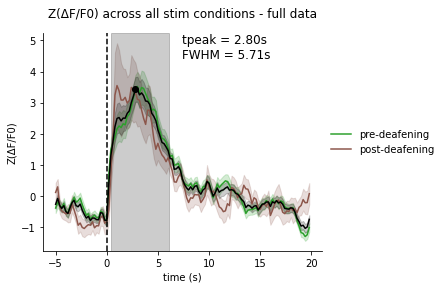

In [26]:
# Add critical stats columns to timeseries data
# plt_data = get_plot_data(trialagg_timeseries, trialagg_stats, fidx)
plt_data = get_plot_data(pos_trialagg_timeseries, pos_trialagg_stats, fidx)

# Variable of interest
ykey = Label.ZSCORE

# Extract plot data for all conditions above ISPTA threshold
logger.info(f'restricting data to conditions above ISPTA threshold ({ISPTA_THR} W/cm2)...')
stim_pltdata = plt_data[plt_data[Label.ISPTA] > ISPTA_THR]

# Plot average trace across datasets
logger.info(f'plotting {ykey} response traces...')
figs[f'{ykey} resp trace merged'], ax = plt.subplots(figsize=(5, 4))
sns.despine(ax=ax)
sns.lineplot(
    ax=ax,
    data=stim_pltdata,
    x=Label.TIME,
    y=ykey,
    errorbar='se',
    hue=Label.DATASET,
    hue_order=hue_order,
    palette=Palette.DEAFENING,
)
sns.lineplot(
    ax=ax,
    data=stim_pltdata,
    x=Label.TIME,
    y=ykey,
    errorbar='se',
    color='k',
)
ax.axvline(0, ls='--', c='k')
ax.set_title(f'{ykey} across all stim conditions - full data', y=1.05)

# Compute and materialize peak features on average trace
logger.info('computing peak features on average trace...')
s = stim_pltdata[ykey].groupby(Label.FRAME).mean()
props = find_response_peak(
    s.loc[fidx.iref:], full_output=True, prominence=0.3 * np.ptp(s), width=1)
tprops = convert_peak_props(props, fps, ioffset=fidx.iref)
tpeak = tprops['index']  # s
ypeak = tprops['value']
FWHM = tprops['widths']  # s
ax.plot(tpeak, ypeak, 'o', c='k')
ax.axvspan(tprops['left_ips'], tprops['right_ips'], color='k', alpha=.2, label='FWHM')

# Mark peak features on figure
txt = [
    f'tpeak = {tpeak:.2f}s',
    f'FWHM = {FWHM:.2f}s',
]

# Compute post-stimulus window size (i.e. number of frames) from extracted FWHM, and save it to file
npost = int(np.round(props['widths']))
logger.info(f'response FWHM = {FWHM:.2f}s, corresponding window size = {npost / fps:.2f}s ({npost} frames)')
save_post_window_size(input_dir, npost)

# Update frame indexer object with corrected post-stimulus window size
fidx.npost = npost

# Add text on axis and legend on right side
ax.text(0.5, 1, '\n'.join(txt), transform=ax.transAxes, va='top', fontsize=12)
if ax.get_legend() is not None:
    sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)

### Plot response traces for each parametric sweep (1 axis per condition)

 2025/06/24 17:23:42: plotting Z(ΔF/F0) vs. P (MPa) response traces...
 2025/06/24 17:23:45: plotting Z(ΔF/F0) vs. DC (%) response traces...


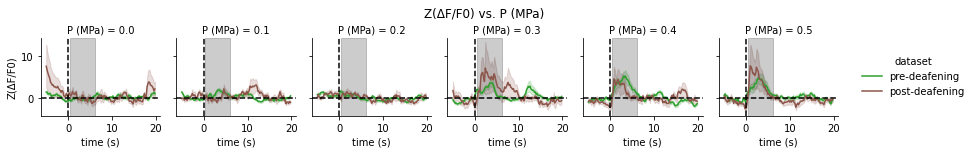

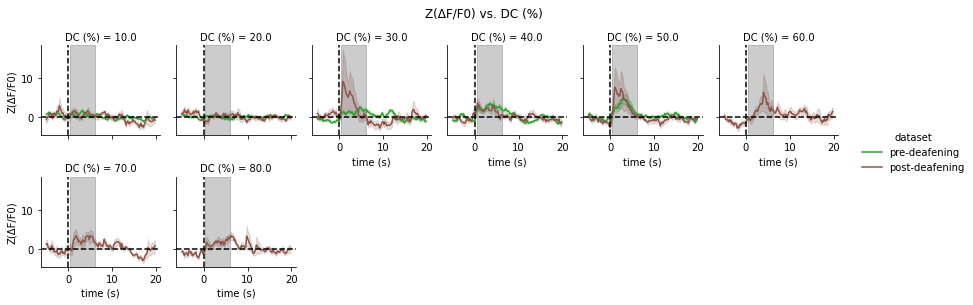

In [27]:
# Facetgrid kwargs
fgkwargs = dict(
    kind='line',
    col_wrap=6,
    height=2,
)

# Compute reference pressure value for duty cycle sweep
p_ref = plt_data[Label.P].max()

# For each input parameter
for xkey in [Label.P, Label.DC]:
    logger.info(f'plotting {ykey_plt} vs. {xkey} response traces...')

    # Plot average traces for each dataset and sweep value
    g = sns.relplot(
        data=get_xdep_data(plt_data, xkey, p_ref=p_ref),
        kind='line',
        x=Label.TIME,
        y=ykey_plt,
        col=xkey,
        hue=Label.DATASET,
        hue_order=hue_order,
        palette=Palette.DEAFENING,
        errorbar='se', 
        col_wrap=6,
        height=2,
    )
    
    # Add vertical line at stimulus onset, and horizontal line at 0 
    g.refline(x=0, y=0, c='k')
    for ax in g.axes:
        ax.axvspan(tprops['left_ips'], tprops['right_ips'], color='k', alpha=.2)

    # Add title
    g.fig.suptitle(f'{ykey_plt} vs. {xkey}', y=1.05)
    figs[f'{ykey} resp traces vs. {xkey} ext.'] = g.fig

## Parameter dependency curves

### Compute and plot initial parameter dependency curves with appropriate response window size

In [28]:
fit_dict = get_fit_table()[mouseline]
logger.info(f'fit_dict:\n{fit_dict}')

 2025/06/24 17:24:10: fit_dict:
parameter
P (MPa)                         poly2
DC (%)              corrected_sigmoid
P_SPTA (MPa)        corrected_sigmoid
P_SPTRMS (MPa)      corrected_sigmoid
I_SPTA (W/cm2)      corrected_sigmoid
I_SPTRMS (W/cm2)    corrected_sigmoid
Name: cre_ndnf, dtype: object


 2025/06/24 17:24:10: applying mean function on Z(ΔF/F0) in [18-26] index window across dataset, ROI, run
 2025/06/24 17:24:10: applying mean function on Z(ΔF/F0) in [26-55] index window across dataset, ROI, run
 2025/06/24 17:24:10: computing evoked Z(ΔF/F0) change...
 2025/06/24 17:24:10: sub-indexing data...
 2025/06/24 17:24:10: filtering data...
 2025/06/24 17:24:10: cross-checking filters...
 2025/06/24 17:24:10: grouping by dataset, averaging, estimating confidence intervals and plotting mean evoked Z(ΔF/F0) change vs. P (MPa) ...
 2025/06/24 17:24:10: sub-indexing data...
 2025/06/24 17:24:10: filtering data...
 2025/06/24 17:24:10: cross-checking filters...
 2025/06/24 17:24:10: grouping by dataset, averaging, estimating confidence intervals and plotting mean evoked Z(ΔF/F0) change vs. DC (%) ...


/tmp/ipykernel_1009664/493246510.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dep_stats[ykey_diff] = compute_evoked_change(


 2025/06/24 17:24:11: adding sample counts per dataset on legend labels...
 2025/06/24 17:24:11: fitting order 2 polynomial to data
 2025/06/24 17:24:11: fitting results: popt = [2.7, 12, -1.3], R2 = 0.83
 2025/06/24 17:24:11: computing fit with sigmoid function: p0 = [40, 40, 5.2]
 2025/06/24 17:24:11: fitting results: popt = [26, 1.6, 3.1], R2 = 0.72


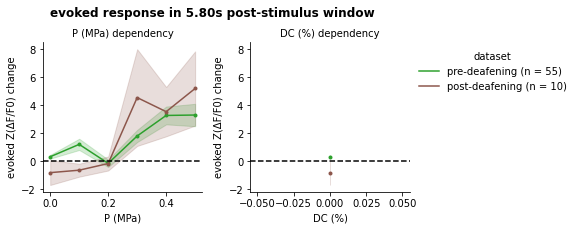

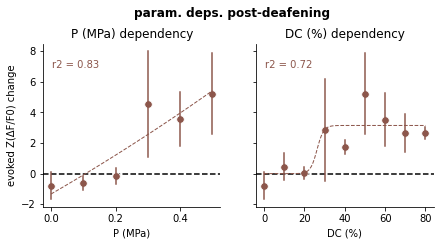

In [29]:
# Re-compute evoked responses with updated window size
dep_timeseries, dep_stats = pos_trialagg_timeseries, pos_trialagg_stats 
# dep_timeseries, dep_stats = pos_trialagg_timeseries, trialagg_stats
ykey_diff = get_change_key(ykey_plt)
dep_stats[ykey_diff] = compute_evoked_change(
    dep_timeseries, ykey_plt, fidx)

# Plot evoked response dependency on input parameters
xkeys = [Label.P, Label.DC]
figs['stimparams'] = plot_stimparams_dependency(
    dep_stats, 
    ykey_diff,
    xkeys=xkeys,
    hue=Label.DATASET,
    hue_order=hue_order,
    palette=Palette.DEAFENING,
    errorbar='se',
    marker='.',
)
figs['stimparams'].suptitle(
    f'evoked response in {npost / fps:.2f}s post-stimulus window', 
    fontsize=12, fontweight='bold', y=1.05)
figs['stimparams'].subplots_adjust(wspace=.3)

# Plot dependencies just for post-deafening dataset, along with fits
dep_stats_post = dep_stats.loc['post-deafening']
c = Palette.DEAFENING['post-deafening']
figs['stimparams postdeaf'], axes = plt.subplots(
    1, len(xkeys), figsize=(3 * len(xkeys) + 1, 3), sharey=True)
for ax, xkey in zip(axes, xkeys):
    sns.despine(ax=ax)
    ax.set_title(f'{xkey} dependency')
    gdata = get_xdep_data(dep_stats_post, xkey, add_DC0=True, p_ref=p_ref)
    ax.axhline(0, ls='--', c='k')
    sns.lineplot(
        ax=ax,
        data=gdata,
        x=xkey,
        y=ykey_diff,
        errorbar='se',
        color=c,
        lw=0,
        err_style='bars',
        marker='.',
        markersize=15,
    )
    fit_data = gdata.groupby(xkey)[ykey_diff].mean()
    compute_and_add_fit(
        ax, 
        fit_data.index.values, 
        fit_data.values, 
        fit_dict.loc[xkey], 
        ls='--', 
        lw=1,
        c=c,
    )
figs['stimparams postdeaf'].suptitle(
    'param. deps. post-deafening', fontsize=12, fontweight='bold', y=1.05);

### Examine relationship between "red-cell-status" and evoked response

 2025/06/24 17:41:55: applying mean function on Z(ΔF/F0) in [18-26] index window across dataset, ROI, run
 2025/06/24 17:41:55: applying mean function on Z(ΔF/F0) in [26-55] index window across dataset, ROI, run
 2025/06/24 17:41:55: computing evoked Z(ΔF/F0) change...
 2025/06/24 17:41:56: comparing distributions of evoked responses between NDNF cells and non-NDNF cells...
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.235e-01 U_stat=8.578e+04


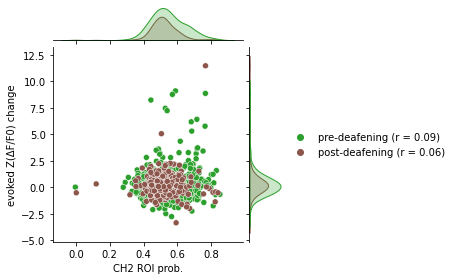

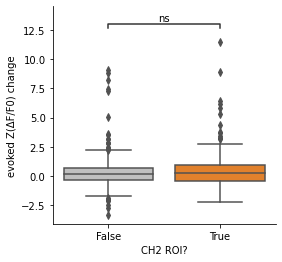

In [30]:
# Compute average evoked response across strong conditions, per ROI
trialagg_stats[ykey_diff] = compute_evoked_change(
    trialagg_timeseries, ykey_plt, fidx)
avg_resp = (
    trialagg_stats[trialagg_stats[Label.ISPTA] > ISPTA_THR]
    [ykey_diff]
    .groupby([Label.DATASET, Label.ROI])
    .mean() 
)
df = pd.concat([coreg_stats, avg_resp.to_frame()], axis=1)

# Plot co-distribution of "red-channel" cell probability and evoked response
g = sns.jointplot(
    data=df, 
    x=Label.CH2_ROI_PROB, 
    y=ykey_diff, 
    hue=Label.DATASET,
    palette=Palette.DEAFENING,
    kind='scatter', 
    height=4
)

# Add correlation coefficient to legend labels
r = (
    df[[Label.CH2_ROI_PROB, ykey_diff]]
    .groupby(Label.DATASET)
    .corr()
    .iloc[0::2, 1]
    .droplevel(1)
)
rmapper = {k: f'{k} (r = {v:.2f})' for k, v in r.items()}
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(
    handles=handles, labels=[rmapper[l] for l in labels],
    loc='center left', bbox_to_anchor=(1.2, 0.5), title=None, frameon=False)

# Compare distributions of evoked responses between red-channel cells and non-red-channel cells
logger.info(f'comparing distributions of evoked responses between {red_channel_key} cells and non-{red_channel_key} cells...')
figs[f'resp strength vs {red_channel_key} status'], ax = plt.subplots(figsize=(4, 4))
sns.despine(ax=ax)
pltkwargs = dict(
    data=df,
    x=Label.CH2_ROI,
    y=ykey_diff,
    palette=Palette.CH2_ROI
)
sns.boxplot(ax=ax, **pltkwargs)
annotator = Annotator(ax, [(False, True)], **pltkwargs)
annotator.configure(test='Mann-Whitney')
annotator.apply_and_annotate();

### Save figures

In [19]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 2024/09/09 15:41:17: saving figures in /gpfs/scratch/lemait01/data/usnm/figs/2024.09.09/figs_main_cre_sst_k0.5_alpha0.7_qadaptive_wq30.0s_aggmedian_classzscore.pdf:


100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


### Notify upon completion

In [20]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'deafening control notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/09/09 15:41:23: deafening control notebook completed in 0:00:42.969068 s
